# 동사무소 -> 집
---
1. 트럭
    - 속도: 30km/h
    - 대기 시간: 1.5min
    - osrm을 통한 경로 추출
2. 로봇
    - 여러 대 배치
    - 속도: 5.76km/h
    - ortools로 각 로봇마다의 경로 추출?(지나가는 집들 정해주기) 
    - 경로를 추출 했으면 osrm으로 경로 시각화

- 트럭과 로봇 전체 이용 가능한 OD 데이터 생성    
    - O: 동사무소 지점, D: 각 집들 지점


# 로봇 네트워크
---
- 12/09 피드백
- from sub to dong / dong to homes 두 개 동시에 시각화

**기본 구성**
- sub - 집까지 직행 네트워크 
- 하나의 동만 정해서 sub부터 출발

**참고**
- 2번째 네트워크와 timestamp, 속도 맞춰줘야 함

**로봇 조건**
- 트럭으로 가는 네트워크가 동사무소까지에서 끝나면 그 시간 이후로 로봇 네트워크 시각화 되도록 수정
- 트럭과 로봇 속도 다르게 구성해야 함
- 로봇 이상 경로 존재했음 - 수정해줘야 함

동사무소를 시작으로 배달해야하는 집들을 모은 데이터

- O: 행운동 주민센터
    37.480612, 126.957058

- D: 집들(20) = [
    [126.9599, 37.48244],  
    [126.960263, 37.482910],   
    [126.960670, 37.482598],   
    [126.960866, 37.481065],  
    [126.960684, 37.480656],  
    [126.960223, 37.481865],  
    [126.960798, 37.482193],   
    [126.959768, 37.483107],  
    [126.959367, 37.483176],  
    [126.958830, 37.482719],  
    [126.958735, 37.482362],  
    [126.959455, 37.482177],   
    [126.958312, 37.481477],   
    [126.960847, 37.479437],    
    [126.963237, 37.480370],    
    [126.961503, 37.481740],   
    [126.959903, 37.480986],   
    [126.959125, 37.481207],   
    [126.958985, 37.479723],   
    [126.962294, 37.479697],  
]

coordinates = [   
    (37.48244, 126.9599),  
    (37.482910, 126.960263),  
    (37.482598, 126.960670),   
    (37.481065, 126.960866),  
    (37.480656, 126.960684),  
    (37.481865, 126.960223),  
    (37.482193, 126.960798),  
    (37.483107, 126.959768),  
    (37.483176, 126.959367),  
    (37.482719, 126.958830),  
    (37.482362, 126.958735),  
    (37.482177, 126.959455),  
    (37.481477, 126.958312),  
    (37.479437, 126.960847),  
    (37.480370, 126.963237),  
    (37.481740, 126.961503),  
    (37.480986, 126.959903),  
    (37.481207, 126.959125),  
    (37.479723, 126.958985),  
    (37.479697, 126.962294)  
]


## 기본 OD 생성

In [100]:
# 라이브러리 불러오기
import numpy as np
import itertools
import requests
import polyline
import json
import os
import math

import random as rd
import pandas as pd
import geopandas as gpd

from datetime import datetime, timedelta

from shapely.geometry import Point

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

import warnings 

warnings.filterwarnings('ignore')

In [101]:
# 변수 설정

## O 데이터 (행운동 주민센터)
O = ['행운동 주민센터'] * 20
O_point = [[126.957058, 37.480612]] * 20  # 좌표 (longitude, latitude)

## D 데이터
D = [
    'home1', 'home2', 'home3', 'home4', 'home5', 'home6', 'home7', 'home8', 'home9', 'home10',
    'home11', 'home12', 'home13', 'home14', 'home15', 'home16', 'home17', 'home18', 'home19', 'home20'
]

# 주어진 좌표 리스트
coordinates = [
    (37.48244, 126.9599),
    (37.482910, 126.960263),
    (37.482598, 126.960670),
    (37.481065, 126.960866),
    (37.480656, 126.960684),
    (37.481865, 126.960223),
    (37.482193, 126.960798),
    (37.483107, 126.959768),
    (37.483176, 126.959367),
    (37.482719, 126.958830),
    (37.482362, 126.958735),
    (37.482177, 126.959455),
    (37.481477, 126.958312),
    (37.479437, 126.960847),
    (37.480370, 126.963237),
    (37.481740, 126.961503),
    (37.480986, 126.959903),
    (37.481207, 126.959125),
    (37.479723, 126.958985),
    (37.479697, 126.962294)
]

# 변환된 결과 리스트
D_point = [[lon, lat] for lat, lon in coordinates]
# 좌표를 WKT 형식으로 변환
O_point_wkt = [f"POINT ({coord[0]} {coord[1]})" for coord in O_point]
D_point_wkt = [f"POINT ({coord[0]} {coord[1]})" for coord in D_point]

# 데이터프레임 구성
OD_data = pd.DataFrame({
    'O': O,
    'O_point': O_point_wkt,
    'D': D,
    'D_point': D_point_wkt
})

# 문자열을 Point 객체로 변환하는 함수
def convert_to_point(point_str):
    # 'POINT (127.127384 37.45091)' -> [127.127384, 37.45091]
    coords = point_str.replace("POINT (", "").replace(")", "").split()
    return Point(float(coords[0]), float(coords[1]))

# 'start_point'와 'end_point'를 Point 객체로 변환
OD_data['O_point'] = OD_data['O_point'].apply(convert_to_point)
OD_data['D_point'] = OD_data['D_point'].apply(convert_to_point)

In [102]:
# OD_data.to_csv("data/OD_data.csv")

## 기본 함수 불러오기

## 로봇 OD 경로 생성

In [103]:
# 로봇 데이터프레임 구성하기

# 변수 설정하기
## 로봇 데이터
speed = [5.76] * 20
duration = [0] * 20
distance = [0] * 20

# 데이터프레임 구성하기
OD_data_robot = OD_data.copy()
OD_data_robot['speed(km/h)'] = speed
OD_data_robot['duration'] = duration
OD_data_robot['distance(단위)'] = distance

In [104]:
OD_data_robot

,O,O_point,D,D_point,speed(km/h),duration,distance(단위)
0,행운동 주민센터,POINT (126.957058 37.480612),home1,POINT (126.9599 37.48244),5.76,0,0
1,행운동 주민센터,POINT (126.957058 37.480612),home2,POINT (126.960263 37.48291),5.76,0,0
2,행운동 주민센터,POINT (126.957058 37.480612),home3,POINT (126.96067 37.482598),5.76,0,0
3,행운동 주민센터,POINT (126.957058 37.480612),home4,POINT (126.960866 37.481065),5.76,0,0
4,행운동 주민센터,POINT (126.957058 37.480612),home5,POINT (126.960684 37.480656),5.76,0,0
5,행운동 주민센터,POINT (126.957058 37.480612),home6,POINT (126.960223 37.481865),5.76,0,0
6,행운동 주민센터,POINT (126.957058 37.480612),home7,POINT (126.960798 37.482193),5.76,0,0
7,행운동 주민센터,POINT (126.957058 37.480612),home8,POINT (126.959768 37.483107),5.76,0,0
8,행운동 주민센터,POINT (126.957058 37.480612),home9,POINT (126.959367 37.483176),5.76,0,0
9,행운동 주민센터,POINT (126.957058 37.480612),home10,POINT (126.95883 37.482719),5.76,0,0


## ortools 사용하기

> ortools를 사용하여 로봇 대수에 따른 각 로봇의 할당 경로 추출   
> 경로 추출 후: osrm으로 경로 시각화

---

### 데이터 준비
`od_data_for_ortools`
- point: 지점명
- point_coord: 지점 좌표(경, 위도)

`calculate_straight_distance` 함수
- 직선 거리 계산 함수    
- 출력값: O-D 사이의 직선 거리(m) 반환

`distance_matrix` 
- od_data_for_ortools 의 point_coord에서 공백과 괄호 제거 후 위도, 경도로 나누기
- caluate_straight_distance 함수를 통해
- 모든 지점 끼리의 거리 행렬 생성

---
로봇 수요량을 임의로 정해서 용량 제한 차량 배치함
- 테스트 상태(돌아가는 지만 확인함)
- 용량말고 시간이나 거리 제한이 가능한지 공부 후 수정 필요
- 용량과 총량은 랜덤으로 돌림
- 로봇 수 3대로 가정

In [105]:
# ortools 사용하기 위한 라이브러리
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

data 모델 만들기 
- `distance_matrix`: 노드 간의 거리를 행렬로 표현
    - 주민센터와 home들의 각각 osrm으로 거리를 추출하여 저장
- `demands`: 각 노드 요구량
    - 각 home들의 요구량을 설정해주기
    - 집들을 전제로 하므로 무게 개념으로 가야할 듯
- `vehicle_capacities`: 각 로봇의 용량
    - demands 설정 값에 따라 달라짐
- `num_vehicle`: 로봇 대수
 - `depot`: 출발지 및 도착지 (기본 노드 0)
    - 출발지 = 도착지 = 주민센터 위치

In [106]:
# 데이터 준비
data = {
    "point": ["행운동 주민센터"] + [f"home{i}" for i in range(1, 21)],
    "point_coord": [
        "POINT (126.957058 37.480612)"
    ] + [
    "POINT (126.9599 37.48244)",
    "POINT (126.960263 37.48291)",
    "POINT (126.96067 37.482598)",
    "POINT (126.960866 37.481065)",
    "POINT (126.960684 37.480656)",
    "POINT (126.960223 37.481865)",
    "POINT (126.960798 37.482193)",
    "POINT (126.959768 37.483107)",
    "POINT (126.959367 37.483176)",
    "POINT (126.95883 37.482719)",
    "POINT (126.958735 37.482362)",
    "POINT (126.959455 37.482177)",
    "POINT (126.958312 37.481477)",
    "POINT (126.960847 37.479437)",
    "POINT (126.963237 37.48037)",
    "POINT (126.961503 37.48174)",
    "POINT (126.959903 37.480986)",
    "POINT (126.959125 37.481207)",
    "POINT (126.958985 37.479723)",
    "POINT (126.962294 37.479697)",
    ],
}

# DataFrame 생성
od_data_for_ortools = pd.DataFrame(data)

# DataFrame 확인
od_data_for_ortools

,point,point_coord
0,행운동 주민센터,POINT (126.957058 37.480612)
1,home1,POINT (126.9599 37.48244)
2,home2,POINT (126.960263 37.48291)
3,home3,POINT (126.96067 37.482598)
4,home4,POINT (126.960866 37.481065)
5,home5,POINT (126.960684 37.480656)
6,home6,POINT (126.960223 37.481865)
7,home7,POINT (126.960798 37.482193)
8,home8,POINT (126.959768 37.483107)
9,home9,POINT (126.959367 37.483176)


In [107]:
# 직선 거리 계산 함수
def calculate_straight_distance(lat1, lon1, lat2, lon2):
    '''
    좌표 거리 생성 함수 
    - 직선 거리 계산 
    - 경로를 모르는 경우 두 지점 간의 대략적인 직선 거리를 계산할 때 사용

    입력값:
        lat1: 출발지 위도 (float)
        lon1: 출발지 경도 (float)
        lat2: 도착지 위도 (float)
        lon2: 도착지 경도 (float)

    출력값:
        두 지점 간의 직선 거리 (미터 단위, float)
    '''
# 직선 거리 계산
# 입력값: 출발지 위도, 경도 / 도착지 위도, 경도
    # 지구 반경 (킬로미터 단위)
    km_constant = 3959* 1.609344
    
    # 위도와 경도를 라디안으로 변환
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    
    # 위도 및 경도 차이 계산
    dlat = lat2 - lat1 # 도착지 위도 - 출발지 위도
    dlon = lon2 - lon1 # 도착지 경도 - 출발지 경도

    # Haversine 공식 계산
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    # 거리 계산 (미터 단위)
    km = km_constant * c
    m = km * 1000
    
    return m # 출발지-도착지 사이의 직선 거리 반환

In [108]:
# 좌표 분리 (공백과 괄호 제거 후 나누기) - 위도, 경도 분리
od_data_for_ortools["longitude"], od_data_for_ortools["latitude"] = zip(
    *od_data_for_ortools["point_coord"].str.replace("POINT ", "").str.replace("[()]", "", regex=True).str.split(" ").apply(lambda x: map(float, x))
)

# 거리 행렬 생성
distance_matrix = pd.DataFrame(index=od_data_for_ortools["point"], columns=[f"{p}_dist" for p in od_data_for_ortools["point"]])

# 거리 계산
for i, row1 in od_data_for_ortools.iterrows():
    for j, row2 in od_data_for_ortools.iterrows():
        if i != j:
            distance = calculate_straight_distance(
                row1["latitude"], row1["longitude"], row2["latitude"], row2["longitude"]
            )
        else:
            distance = 0  # 동일 지점은 거리 0
        distance_matrix.iloc[i, j] = distance

In [109]:
distance_matrix

,행운동 주민센터_dist,home1_dist,home2_dist,home3_dist,home4_dist,home5_dist,home6_dist,home7_dist,home8_dist,home9_dist,...,home11_dist,home12_dist,home13_dist,home14_dist,home15_dist,home16_dist,home17_dist,home18_dist,home19_dist,home20_dist
point,,,,,,,,,,,,,,,,,,,,,
행운동 주민센터,0,322.8266,381.168711,387.771648,339.791508,320.01444,312.120923,373.94028,366.286545,350.442823,...,244.479197,273.912546,146.621314,358.987025,545.931694,411.815245,254.478479,194.031824,196.697287,473.125324
home1,322.8266,0,61.299841,70.181949,175.058923,210.101271,70.006099,83.867656,75.080632,94.396276,...,103.168469,48.962497,176.364263,344.236564,373.764129,161.457644,161.687611,153.221053,312.738354,371.040421
home2,381.168711,61.299841,0,49.936067,211.95522,253.38706,116.259459,92.660245,48.865593,84.417135,...,147.966194,108.294777,234.5914,389.627013,385.555375,170.001969,216.297815,214.354634,371.911169,399.722988
home3,387.771648,70.181949,49.936067,0,171.347486,215.957398,90.553391,46.43152,97.668235,131.725586,...,172.755208,116.990902,242.561267,351.855691,335.702842,120.443027,191.609395,206.189384,352.591415,352.995674
home4,339.791508,175.058923,211.95522,171.347486,0,48.233926,105.51625,125.579059,246.881653,269.450024,...,236.989208,175.482809,229.985852,181.044268,223.046682,93.77595,85.432539,154.443189,223.210696,197.538325
home5,320.01444,210.101271,253.38706,215.957398,48.233926,0,140.462903,171.212937,284.288989,303.371687,...,256.065999,200.921657,228.360286,136.316004,227.524071,140.54832,78.080162,150.601465,182.327088,177.646011
home6,312.120923,70.006099,116.259459,90.553391,105.51625,140.462903,0,62.489336,143.830325,164.192284,...,142.463327,76.135762,174.066359,275.555866,313.652039,113.804155,101.743531,121.416761,262.0524,302.525609
home7,373.94028,83.867656,92.660245,46.43152,125.579059,171.212937,62.489336,0,136.350205,167.016306,...,183.013269,118.524176,233.37603,306.502619,295.666864,80.049248,155.732942,183.894669,317.866068,307.355041
home8,366.286545,75.080632,48.865593,97.668235,246.881653,284.288989,143.830325,136.350205,0,36.207475,...,123.176824,107.042406,222.176621,419.070705,431.674428,215.749951,236.159643,218.769638,382.597687,439.861164


`create_data_model` 함수

- `distance_matrix`: 계산한 거리 행렬
- `demands`: 각 지점의 요구량(무게 개념으로 인식)
- `vehicle_capacities`: 각 로봇의 용량(무게 개념으로 인식)
- `depot`: 출발지 및 도착지 (주민센터)

In [110]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    # 거리 행렬 정의 (노드 간 거리)
    # 저장된 거리 행렬을 사용
    data["distance_matrix"] = distance_matrix.values.tolist() # df를 리스트로 변환
    
    # 각 노드의 요구량 (임의로 설정 / 무게로 인식)
    data["demands"] = [0, 2, 4, 1, 5, 3, 2, 2, 4, 3, 1, 2, 6, 1, 3, 3, 3, 4, 2, 7, 2]
    
    # 각 로봇의 용량
    data["vehicle_capacities"] = [20, 20, 20]
    # 로봇 대수
    data["num_vehicles"] = 3
    # 출발지 및 도착지 (기본 노드 0) = 주민센터
    data["depot"] = 0
    return data

In [111]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")  # 최적화 목표값 출력

    # 변수 초기화
    total_distance = 0  # 전체 경로 거리
    total_load = 0  # 전체 적재량
    
    # 각 차량별 경로 출력
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)  # 차량의 시작 노드
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0  # 차량 경로 거리
        route_load = 0  # 차량 적재량
        while not routing.IsEnd(index):  # 차량이 종착점에 도달할 때까지 반복
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))  # 다음 노드로 이동
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)  # 차량 경로 정보 출력
        total_distance += route_distance
        total_load += route_load
    
    # 전체 거리 및 적재량 출력
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")

In [112]:
def main():
    """Solve the CVRP problem and save the results to a DataFrame."""
    # 문제 데이터 생성
    data = create_data_model()

    # 라우팅 인덱스 매니저 생성
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]), data["num_vehicles"], data["depot"])

    # 라우팅 모델 생성
    routing = pywrapcp.RoutingModel(manager)

    # 거리 콜백 함수 생성 및 등록
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # 모든 차량의 비용 함수 설정
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # 수요(적재량) 콜백 함수 생성 및 등록
    def demand_callback(from_index):
        """Returns the demand of the node."""
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

    # 용량 제약 추가
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # 여유 용량
        data["vehicle_capacities"],  # 차량 최대 용량
        True,  # 시작 누적량을 0으로 설정
        "Capacity",
    )

    # 초기 솔루션 전략 및 탐색 파라미터 설정
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC  # 초기 전략
    search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH  # 지역 탐색
    search_parameters.time_limit.FromSeconds(1)  # 제한 시간 설정

    # 문제 해결
    solution = routing.SolveWithParameters(search_parameters)

    # 솔루션 출력 및 저장
    if solution:
        # 결과 저장을 위한 리스트
        results = []
        for vehicle_id in range(data["num_vehicles"]):
            index = routing.Start(vehicle_id)
            route_nodes = []
            route_distance = 0
            route_load = 0
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                route_nodes.append(node_index)
                route_load += data["demands"][node_index]
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
            route_nodes.append(manager.IndexToNode(index))  # 종착점 추가
            # 결과 리스트에 추가
            results.append({
                "Vehicle": vehicle_id,
                "Route": " -> ".join(map(str, route_nodes)),
                "Distance": route_distance,
                "Load": route_load
            })
        print_solution(data, manager, routing, solution)
        # DataFrame으로 변환
        df_routes = pd.DataFrame(results)
        # DataFrame 출력
        # 필요하다면 CSV로 저장
        # df_routes.to_csv("routes_results.csv", index=False)
        return df_routes

In [113]:
route_data_robot = main()

Objective: 0
Route for vehicle 0:
 0 Load(0) ->  8 Load(4) ->  6 Load(6) ->  5 Load(9) ->  4 Load(14) ->  2 Load(18) ->  1 Load(20) ->  0 Load(20)
Distance of the route: 0m
Load of the route: 20

Route for vehicle 1:
 0 Load(0) ->  15 Load(3) ->  14 Load(6) ->  12 Load(12) ->  11 Load(14) ->  9 Load(17) ->  7 Load(19) ->  3 Load(20) ->  0 Load(20)
Distance of the route: 0m
Load of the route: 20

Route for vehicle 2:
 0 Load(0) ->  20 Load(2) ->  19 Load(9) ->  18 Load(11) ->  17 Load(15) ->  16 Load(18) ->  13 Load(19) ->  10 Load(20) ->  0 Load(20)
Distance of the route: 0m
Load of the route: 20

Total distance of all routes: 0m
Total load of all routes: 60


In [114]:
route_data_robot

,Vehicle,Route,Distance,Load
0,0,0 -> 8 -> 6 -> 5 -> 4 -> 2 -> 1 -> 0,0,20
1,1,0 -> 15 -> 14 -> 12 -> 11 -> 9 -> 7 -> 3 -> 0,0,20
2,2,0 -> 20 -> 19 -> 18 -> 17 -> 16 -> 13 -> 10 -> 0,0,20


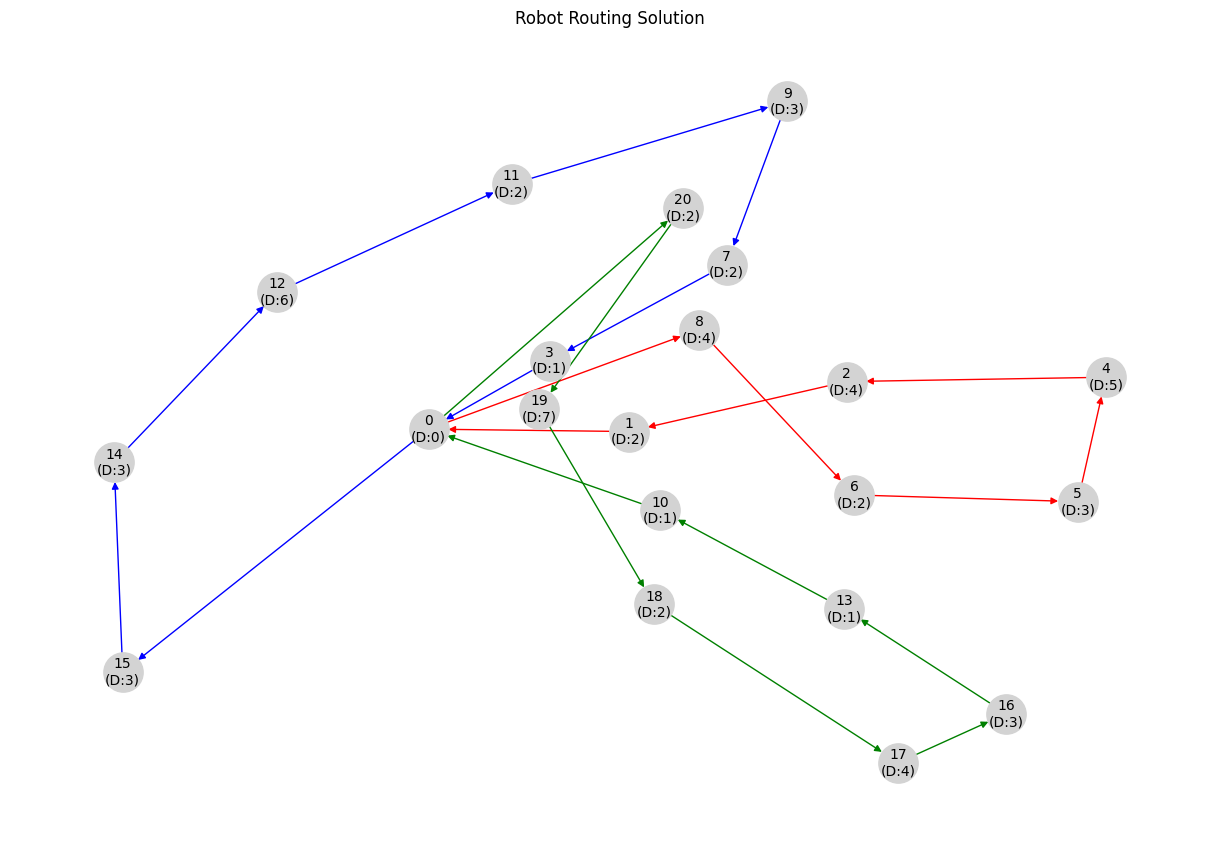

In [115]:
import matplotlib.pyplot as plt
import networkx as nx

# 데이터를 기반으로 생성된 경로 결과를 하드코딩
vehicle_routes = [
    [0, 8, 6, 5, 4, 2, 1, 0],  # 로봇 1
    [0, 15, 14, 12, 11, 9, 7, 3, 0],  # 로봇 2
    [0, 20, 19, 18, 17, 16, 13, 10, 0],  # 로봇 3
]

# 노드별 수요
demands = [0, 2, 4, 1, 5, 3, 2, 2, 4, 3, 1, 2, 6, 1, 3, 3, 3, 4, 2, 7, 2]

# 시각화를 위한 색상 설정
colors = ["red", "blue", "green"]

# 그래프 생성
G = nx.DiGraph()

# 노드 추가 및 라벨링 (수요 포함)
for i, demand in enumerate(demands):
    G.add_node(i, demand=demand)

# 경로 추가 및 색상 부여
for vehicle_id, route in enumerate(vehicle_routes):
    for i in range(len(route) - 1):
        G.add_edge(route[i], route[i + 1], color=colors[vehicle_id])

# 엣지 색상 추출
edges = G.edges()
edge_colors = [G[u][v]["color"] for u, v in edges]

# 그래프 레이아웃 설정
pos = nx.spring_layout(G, seed=42)

# 그래프 시각화
plt.figure(figsize=(12, 8))
nx.draw(
    G,
    pos,
    # with_labels=True,
    edge_color=edge_colors,
    node_color="lightgrey",
    node_size=800,
)

# 노드에 수요 정보 추가
demand_labels = {node: f"{node}\n(D:{data['demand']})" for node, data in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=demand_labels, font_size=10)

plt.title("Robot Routing Solution")
plt.savefig("image/robot_routing_solution.png")
plt.show()

In [116]:
import folium

# 노드 좌표 데이터 (경위도)
node_coords = {
    0: (37.480612, 126.957058),  # 행운동 주민센터
    1: (37.48244, 126.9599),
    2: (37.482910, 126.960263),
    3: (37.482598, 126.960670),
    4: (37.481065, 126.960866),
    5: (37.480656, 126.960684),
    6: (37.481865, 126.960223),
    7: (37.482193, 126.960798),
    8: (37.483107, 126.959768),
    9: (37.483176, 126.959367),
    10: (37.482719, 126.958830),
    11: (37.482362, 126.958735),
    12: (37.482177, 126.959455),
    13: (37.481477, 126.958312),
    14: (37.479437, 126.960847),
    15: (37.480370, 126.963237),
    16: (37.481740, 126.961503),
    17: (37.480986, 126.959903),
    18: (37.481207, 126.959125),
    19: (37.479723, 126.958985),
    20: (37.479697, 126.962294)
}

# 경로 결과
vehicle_routes = [
    [0, 8, 6, 5, 4, 2, 1, 0],  # 로봇 1
    [0, 15, 14, 12, 11, 9, 7, 3, 0],  # 로봇 2
    [0, 20, 19, 18, 17, 16, 13, 10, 0],  # 로봇 3
]

# 색상 설정
colors = ["red", "blue", "green"]

# 지도 생성 (중심: 행운동 주민센터 좌표)
map_center = node_coords[0]
m = folium.Map(location=map_center, zoom_start=16)

# 노드 색상 매핑
node_colors = ["gray"] * len(node_coords)  # 기본 색상: gray
for vehicle_id, route in enumerate(vehicle_routes):
    for node in route:
        node_colors[node] = colors[vehicle_id]  # 경로에 속한 노드는 해당 경로의 색상

# 노드 표시
for node, coord in node_coords.items():
    folium.Marker(
        location=coord,
        popup=f"Node {node}",
        icon=folium.Icon(color=node_colors[node]),
    ).add_to(m)

# 경로 시각화
for vehicle_id, route in enumerate(vehicle_routes):
    route_coords = [node_coords[node] for node in route]
    folium.PolyLine(
        locations=route_coords,
        color=colors[vehicle_id],
        weight=5,
        opacity=0.7,
        popup=f"Robot {vehicle_id + 1} Route",
    ).add_to(m)

# 결과 지도 저장 또는 표시
m.save("visualization/route_visualization_robot.html")
m

## react 시각화

In [117]:
od_data_for_ortools

,point,point_coord,longitude,latitude
0,행운동 주민센터,POINT (126.957058 37.480612),126.957058,37.480612
1,home1,POINT (126.9599 37.48244),126.959900,37.482440
2,home2,POINT (126.960263 37.48291),126.960263,37.482910
3,home3,POINT (126.96067 37.482598),126.960670,37.482598
4,home4,POINT (126.960866 37.481065),126.960866,37.481065
5,home5,POINT (126.960684 37.480656),126.960684,37.480656
6,home6,POINT (126.960223 37.481865),126.960223,37.481865
7,home7,POINT (126.960798 37.482193),126.960798,37.482193
8,home8,POINT (126.959768 37.483107),126.959768,37.483107
9,home9,POINT (126.959367 37.483176),126.959367,37.483176


In [118]:
# react에 사용할 od_data 생성

point_lookup = od_data_for_ortools.set_index("point")[["longitude", "latitude"]].to_dict("index")

# Generate OD data for each vehicle
robot_path = []
for _, row in route_data_robot.iterrows():
    vehicle = row["Vehicle"]
    route_str = row["Route"]  # 전체 Route 문자열 그대로 저장
    route = list(map(int, row["Route"].split(" -> ")))  # Split route into integers for processing
    origin = route[0]  # 출발지는 route의 첫 번째 값
    destination = route[-1]  # 도착지는 route의 마지막 값 (항상 0)

    robot_path.append({
        # "Vehicle": vehicle,
        "O_point": od_data_for_ortools.loc[origin, "point"],
        "O_coord": [od_data_for_ortools.loc[origin, "longitude"], od_data_for_ortools.loc[origin, "latitude"]],
        "D_point": od_data_for_ortools.loc[destination, "point"],
        "D_coord": [od_data_for_ortools.loc[destination, "longitude"], od_data_for_ortools.loc[destination, "latitude"]],
        "route": route_str  # 전체 Route 문자열
    })

od_data_for_react = pd.DataFrame(robot_path)

In [119]:
od_data_for_react

,O_point,O_coord,D_point,D_coord,route
0,행운동 주민센터,"[126.957058, 37.480612]",행운동 주민센터,"[126.957058, 37.480612]",0 -> 8 -> 6 -> 5 -> 4 -> 2 -> 1 -> 0
1,행운동 주민센터,"[126.957058, 37.480612]",행운동 주민센터,"[126.957058, 37.480612]",0 -> 15 -> 14 -> 12 -> 11 -> 9 -> 7 -> 3 -> 0
2,행운동 주민센터,"[126.957058, 37.480612]",행운동 주민센터,"[126.957058, 37.480612]",0 -> 20 -> 19 -> 18 -> 17 -> 16 -> 13 -> 10 -> 0


In [120]:
# Route를 좌표로 변환하는 함수(geometry)
def get_coordinates_from_route(route, coord_data):
    """
    Given a route in the format "0 -> 8 -> 7 -> ..." and a dataset mapping points to coordinates,
    extract the coordinates in the sequence of the route.
    """
    points = route.replace(" ", "").split("->")
    coordinates = [
        coord_data.loc[int(point), ["longitude", "latitude"]].tolist()
        for point in points
    ]
    return coordinates

# Extract routes with coordinates
od_data_for_react["geometry"] = od_data_for_react["route"].apply(
    lambda r: get_coordinates_from_route(r, od_data_for_ortools)
)

In [121]:
od_data_for_react.to_csv("data/OD_data_robot_with_path.csv")

In [122]:
od_data_for_react["start_time"] = [0] * 3

In [123]:
od_data_for_react

,O_point,O_coord,D_point,D_coord,route,geometry,start_time
0,행운동 주민센터,"[126.957058, 37.480612]",행운동 주민센터,"[126.957058, 37.480612]",0 -> 8 -> 6 -> 5 -> 4 -> 2 -> 1 -> 0,"[[126.957058, 37.480612], [126.959768, 37.4831...",0
1,행운동 주민센터,"[126.957058, 37.480612]",행운동 주민센터,"[126.957058, 37.480612]",0 -> 15 -> 14 -> 12 -> 11 -> 9 -> 7 -> 3 -> 0,"[[126.957058, 37.480612], [126.963237, 37.4803...",0
2,행운동 주민센터,"[126.957058, 37.480612]",행운동 주민센터,"[126.957058, 37.480612]",0 -> 20 -> 19 -> 18 -> 17 -> 16 -> 13 -> 10 -> 0,"[[126.957058, 37.480612], [126.962294, 37.4796...",0


In [124]:
def calculate_route_with_timestamps(osrm_base_url, geometry, start_time, speed=5.76):
    '''
    OSRM을 이용하여 경로를 계산하고 타임스탬프를 생성합니다.

    Args:
        osrm_base_url (str): OSRM 서버의 기본 URL
        geometry (list): 경유 좌표 리스트
        start_time (int): 경로 시작 시간 (초 단위)
        speed (float): 차량 속도 (m/s)
    
    Returns:
        dict: React에서 사용할 결과 형식
    '''
    # Convert geometry coordinates to OSRM request format
    coords = ';'.join([f"{lon},{lat}" for lon, lat in geometry])
    
    # OSRM 요청 URL 생성
    route_url = f"{osrm_base_url}/route/v1/driving/{coords}?overview=full&geometries=polyline&steps=false"
    
    # OSRM 요청
    response = requests.get(route_url)
    if response.status_code != 200:
        raise Exception(f"OSRM 요청 실패: {response.status_code} - {response.text}")
    
    data = response.json()
    if not data.get("routes"):
        raise Exception("OSRM 결과에서 경로를 찾을 수 없습니다.")
    
    # 결과 처리
    route_geometry = [(lon, lat) for lat, lon in polyline.decode(data["routes"][0]["geometry"])]
    total_distance_m = data["routes"][0]["distance"]  # 전체 거리 (m)
    total_duration_s = data["routes"][0]["duration"]  # 전체 시간 (초)
    
    # 거리와 속도를 기반으로 타임스탬프 계산
    timestamps = [0]  # 첫 번째 좌표에서 시작
    cumulative_time = 0  # 시작 시간은 0
    distances = [0] + [total_distance_m * i / (len(route_geometry) - 1) for i in range(1, len(route_geometry))]
    
    for i in range(len(distances) - 1):
        segment_distance = distances[i + 1] - distances[i]
        cumulative_time += segment_distance / speed
        timestamps.append(cumulative_time)
    
    # 사용자 정의 시작 시간을 모든 타임스탬프에 더함
    timestamps = [t + start_time for t in timestamps]
    
    # 결과 저장
    result = {
        "route": route_geometry,
        "timestamp": timestamps,
        "duration": total_duration_s,  # 전체 소요 시간
        "distance": total_distance_m,  # 전체 거리
    }
    return result

In [125]:
osrm_base_url = "http://router.project-osrm.org"

# 데이터프레임 처리
results = []

for index, row in od_data_for_react.iterrows():
    result = calculate_route_with_timestamps(
        osrm_base_url=osrm_base_url,
        geometry=row['geometry'],
        start_time=row['start_time'],
        speed=5.76
    )
    results.append(result)

# 결과를 데이터프레임에 추가
result_robot = results

In [126]:
result_robot

[{'route': [(126.95718, 37.48066),
   (126.95713, 37.48073),
   (126.95733, 37.48085),
   (126.95748, 37.48099),
   (126.95739, 37.48105),
   (126.95742, 37.48109),
   (126.95781, 37.4815),
   (126.95809, 37.48179),
   (126.95799, 37.48184),
   (126.95809, 37.48193),
   (126.95838, 37.48232),
   (126.95865, 37.48272),
   (126.95875, 37.48279),
   (126.95879, 37.48285),
   (126.95883, 37.48295),
   (126.95885, 37.48297),
   (126.95895, 37.48301),
   (126.95903, 37.48308),
   (126.95914, 37.48312),
   (126.95922, 37.48326),
   (126.95934, 37.48334),
   (126.95947, 37.48342),
   (126.95949, 37.48349),
   (126.9595, 37.48359),
   (126.95953, 37.48356),
   (126.95975, 37.48343),
   (126.95978, 37.48338),
   (126.95977, 37.48333),
   (126.95974, 37.48325),
   (126.95984, 37.48317),
   (126.96007, 37.48302),
   (126.96009, 37.483),
   (126.96046, 37.48278),
   (126.9608, 37.48257),
   (126.96031, 37.48208),
   (126.96014, 37.48192),
   (126.95972, 37.48149),
   (126.96005, 37.48128),
   (126.

In [128]:
# 트럭이 동사무소로 도착하는 시간에 맞춰 로봇의 출발 시간을 조정
# 타임스탬프의 시작 시간을 600으로 변경하는 함수
def adjust_timestamps(data_list):
    for entry in data_list:
        timestamps = entry['timestamp']
        offset = 600 - timestamps[0]  # 시작 시간을 600으로 변경하기 위한 오프셋 계산
        entry['timestamp'] = [t + offset for t in timestamps]
    return data_list


# 타임스탬프 업데이트
updated_result_robot = adjust_timestamps(result_robot)

In [135]:
final_result_robot_df = pd.DataFrame(updated_result_robot)
final_result_robot_df

,route,timestamp,duration,distance
0,"[(126.95718, 37.48066), (126.95713, 37.48073),...","[600, 604.4167605105105, 608.833521021021, 613...",522.3,1882.6
1,"[(126.95718, 37.48066), (126.95724, 37.48057),...","[600, 604.9196300287356, 609.8392600574713, 61...",657.6,3287.1
2,"[(126.95718, 37.48066), (126.95724, 37.48057),...","[600, 604.9688064588979, 609.9376129177958, 61...",758.5,3520.3


In [136]:
# 가장 마지막 행의 가장 마지막 timestamp 값 가져오기
robot_last_timestamp = final_result_robot_df.iloc[-1]['timestamp'][-1]
print(f"Robot route's last timestamp: {robot_last_timestamp}")

Robot route's last timestamp: 1211.163194444445


In [137]:
# distance 열 값 모두 더하기
robot_total_distance = final_result_robot_df['distance'].sum()
print(f"Total Distance: {robot_total_distance}")

Total Distance: 8690.0


In [138]:
# 데이터 저장
path = 'react/public/data/'

with open(os.path.join(path + 'trips_foot.json'), 'w', encoding='utf-8') as file:
    json.dump(updated_result_robot, file)
    

In [ ]:
import folium

def visualize_route_with_lines(df, start_point, stops):
    """
    데이터프레임의 경로 데이터를 folium으로 시각화하고 경로를 선으로 표현하는 함수.

    Args:
        df (DataFrame): 경로 데이터가 포함된 데이터프레임
        start_point (tuple): 시작 지점의 위도와 경도 (latitude, longitude)
        stops (list): 정류장의 위도와 경도 리스트 (latitude, longitude) 리스트
    """
    # 지도 초기화 (시작 지점을 중심으로 설정)
    m = folium.Map(location=[start_point[0], start_point[1]], zoom_start=16)

    # 데이터프레임의 각 경로를 지도에 추가
    for idx, row in df.iterrows():
        route = row["route"]  # 경로 데이터 (좌표 리스트)
        route_latlon = [[coord[1], coord[0]] for coord in route]  # [latitude, longitude] 형식으로 변환
        folium.PolyLine(
            locations=route_latlon,  # 변환된 경로 좌표 리스트
            color="blue",
            weight=5,
            opacity=0.7,
            tooltip=f"Route {idx+1}: Distance {row['distance']} m, Duration {row['duration']} min"
        ).add_to(m)

    # 시작 지점 표시
    folium.Marker(
        location=[start_point[0], start_point[1]],
        icon=folium.Icon(color="green"),
        tooltip="Start Point: 행운동 주민센터"
    ).add_to(m)

    # 정류장 표시
    for i, stop in enumerate(stops, start=1):
        folium.Marker(
            location=[stop[0], stop[1]],
            icon=folium.Icon(color="red", icon="info-sign"),
            tooltip=f"Home {i}"  # 정류장 이름
        ).add_to(m)

    # 마지막 지점 표시 (돌아온 시작 지점)
    folium.Marker(
        location=[start_point[0], start_point[1]],
        icon=folium.Icon(color="blue", icon="flag"),
        tooltip="행운동 주민센터 (End Point)"
    ).add_to(m)

    # 지도 반환
    return m


# 시작 지점 (행운동 주민센터)
start_point = (37.480612, 126.957058)

# 정류장 (각 경로의 도착지)
stops = [
    (37.48244, 126.9599), # 1
    (37.482910, 126.960263),# 2
    (37.482598, 126.960670),# 3
    (37.481065, 126.960866),# 4
    (37.480656, 126.960684),# 5
    (37.481865, 126.960223),# 6
    (37.482193, 126.960798),# 7
    (37.483107, 126.959768),# 8
    (37.483176, 126.959367),# 9
    (37.482719, 126.958830),# 10
    (37.482362, 126.958735),# 11
    (37.482177, 126.959455),# 12
    (37.481477, 126.958312),# 13
    (37.479437, 126.960847),# 14
    (37.480370, 126.963237),# 15
    (37.481740, 126.961503),# 16
    (37.480986, 126.959903),# 17
    (37.481207, 126.959125),# 18
    (37.479723, 126.958985),# 19
    (37.479697, 126.962294) # 20
]

# 경로 시각화 실행
map_visualization = visualize_route_with_lines(final_result_robot_df, start_point, stops)

# 지도 저장 및 출력
map_visualization.save("visualization/route_visualization_robot.html")
map_visualization

In [141]:
import folium

def visualize_route_with_lines(df, start_point, stops):
    """
    데이터프레임의 경로 데이터를 folium으로 시각화하고 경로를 선으로 표현하는 함수.

    Args:
        df (DataFrame): 경로 데이터가 포함된 데이터프레임
        start_point (tuple): 시작 지점의 위도와 경도 (latitude, longitude)
        stops (list): 정류장의 위도와 경도 리스트 (latitude, longitude) 리스트
    """
    # 색상 리스트 (행별로 다른 색상 지정)
    colors = [
        "blue", "red", "green", "purple", "orange", "darkred", "lightred", "beige",
        "darkblue", "darkgreen", "cadetblue", "pink", "lightblue", "lightgreen", "gray"
    ]

    # 지도 초기화 (시작 지점을 중심으로 설정)
    m = folium.Map(location=[start_point[0], start_point[1]], zoom_start=16)

    # 데이터프레임의 각 경로를 지도에 추가
    for idx, row in df.iterrows():
        route = row["route"]  # 경로 데이터 (좌표 리스트)
        route_latlon = [[coord[1], coord[0]] for coord in route]  # [latitude, longitude] 형식으로 변환
        
        # 행별 색상 순환
        color = colors[idx % len(colors)]

        folium.PolyLine(
            locations=route_latlon,  # 변환된 경로 좌표 리스트
            color=color,
            weight=5,
            opacity=0.7,
            tooltip=f"Route {idx + 1}: Distance {row['distance']} m, Duration {row['duration']} min"
        ).add_to(m)

        # 경로의 중간 지점에 인덱스 마커 추가
        midpoint = route_latlon[len(route_latlon) // 2]  # 경로의 중간 좌표
        folium.Marker(
            location=midpoint,
            icon=folium.DivIcon(html=f'<div style="background-color: {color}; color: white; padding: 2px 5px; border-radius: 3px; font-weight: bold;">{idx + 1}</div>')
        ).add_to(m)

    # 시작 지점 표시
    folium.Marker(
        location=[start_point[0], start_point[1]],
        icon=folium.Icon(color="green"),
        tooltip="Start Point: 행운동 주민센터"
    ).add_to(m)

    # 정류장 표시
    for i, stop in enumerate(stops, start=1):
        folium.Marker(
            location=[stop[0], stop[1]],
            icon=folium.Icon(color="red", icon="info-sign"),
            tooltip=f"Home {i}"
        ).add_to(m)

    # 마지막 지점 표시 (돌아온 시작 지점)
    folium.Marker(
        location=[start_point[0], start_point[1]],
        icon=folium.Icon(color="blue", icon="flag"),
        tooltip="행운동 주민센터 (End Point)"
    ).add_to(m)

    # 지도 반환
    return m

# 시작 지점 (행운동 주민센터)
start_point = (37.480612, 126.957058)

# 정류장 (각 경로의 도착지)
stops = [
    (37.48244, 126.9599), # 1
    (37.482910, 126.960263),# 2
    (37.482598, 126.960670),# 3
    (37.481065, 126.960866),# 4
    (37.480656, 126.960684),# 5
    (37.481865, 126.960223),# 6
    (37.482193, 126.960798),# 7
    (37.483107, 126.959768),# 8
    (37.483176, 126.959367),# 9
    (37.482719, 126.958830),# 10
    (37.482362, 126.958735),# 11
    (37.482177, 126.959455),# 12
    (37.481477, 126.958312),# 13
    (37.479437, 126.960847),# 14
    (37.480370, 126.963237),# 15
    (37.481740, 126.961503),# 16
    (37.480986, 126.959903),# 17
    (37.481207, 126.959125),# 18
    (37.479723, 126.958985),# 19
    (37.479697, 126.962294) # 20
]

# 경로 시각화 실행
map_visualization = visualize_route_with_lines(final_result_robot_df, start_point, stops)

# 지도 저장 및 출력
map_visualization.save("visualization/route_visualization_robot.html")
map_visualization
